# -------------------
# TIỀN XỬ LÝ DỮ LIỆU 
# -------------------

In [1]:
import numpy as np
if not hasattr(np, 'complex'):
    np.complex = complex

import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# CẤU HÌNH ĐƯỜNG DẪN 
BASE_DIR = r'C:\Users\ADMIN\OneDrive\Documents\BTAPKPDL\cuoiki\code\archive'
CSV_PATH = os.path.join(BASE_DIR, 'metadata', 'UrbanSound8K.csv')
AUDIO_DIR = os.path.join(BASE_DIR, 'audio')

# ĐỌC METADATA
df = pd.read_csv(CSV_PATH)
print(" Dữ liệu metadata (5 dòng đầu):")
print(df.head())

# KIỂM TRA GIÁ TRỊ THIẾU
missing = df.isnull().sum()
print("\n Kiểm tra dữ liệu thiếu:")
print(missing)

# LOẠI BỎ DÒNG BỊ THIẾU
df = df.dropna().reset_index(drop=True)
print(f"\n Đã loại bỏ {missing.sum()} giá trị thiếu. Còn lại {len(df)} dòng dữ liệu.")

# LỌC CÁC FILE ÂM THANH TỒN TẠI
def get_valid_df(df, audio_dir):
    valid_rows = []
    for _, row in df.iterrows():
        fold = f"fold{row['fold']}"
        path = os.path.join(audio_dir, fold, row['slice_file_name'])
        if os.path.exists(path):
            valid_rows.append(row)
    return pd.DataFrame(valid_rows).reset_index(drop=True)

df = get_valid_df(df, AUDIO_DIR)
print("\n Sau lọc file tồn tại (5 dòng đầu):")
print(df.head())
print(f" Số file hợp lệ: {len(df)}")

# XEM THỬ 1 FILE ÂM THANH (fold8)
sample_path = os.path.join(AUDIO_DIR, 'fold8', '4918-3-1-0.wav')
if os.path.exists(sample_path):
    y, sr = librosa.load(sample_path)
    print(f"\n Sample file: {sample_path}")
    print(f"Sample rate: {sr}, Duration: {len(y)/sr:.2f} sec")
    ipd.display(ipd.Audio(sample_path))
else:
    print(f"\n Không tìm thấy file: {sample_path}")

 Dữ liệu metadata (5 dòng đầu):
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

 Kiểm tra dữ liệu thiếu:
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

 Đã loại bỏ 0 giá trị thiếu. Còn lại 8732 dòng dữ liệu.

 Sau lọc file tồn tại (5 dòng đầu):
      slice_file_name    fsID  start        end  salience  fold  classID  \
0 

In [3]:
# TRÍCH XUẤT MEL-SPECTROGRAM
def extract_mel_spectrogram(file_path, n_mels=128, max_len=174):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_mel = librosa.power_to_db(mel, ref=np.max)

        if log_mel.shape[1] < max_len:
            pad_width = max_len - log_mel.shape[1]
            log_mel = np.pad(log_mel, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel = log_mel[:, :max_len]

        return log_mel
    except:
        return None

In [4]:
# XỬ LÝ TOÀN BỘ DỮ LIỆU 
X, y, paths = [], [], []
for _, row in df.iterrows():
    fold = f"fold{row['fold']}"
    file_path = os.path.join(AUDIO_DIR, fold, row['slice_file_name'])
    mel_spec = extract_mel_spectrogram(file_path)
    if mel_spec is not None:
        X.append(mel_spec)
        y.append(row['class'])
        paths.append(file_path)

X = np.array(X)[..., np.newaxis]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = tf.keras.utils.to_categorical(y_encoded)

print(f"\n Số lượng mẫu sau trích xuất: {len(X)}")
print("\n 20 dòng đầu tiên của Mel-spectrogram :")
for i in range(min(20, len(X))):
    print(f"Mẫu {i + 1}:\n{X[i][:5, :5, 0]}\n")



 Số lượng mẫu sau trích xuất: 8732

 20 dòng đầu tiên của Mel-spectrogram :
Mẫu 1:
[[-72.605446 -66.374306 -65.6224   -72.332405 -69.60476 ]
 [-70.40237  -65.4344   -63.471382 -61.759293 -55.584595]
 [-66.927765 -62.386124 -62.35012  -59.205566 -57.579514]
 [-60.496597 -55.29575  -55.15779  -55.210693 -53.103043]
 [-65.47597  -57.885742 -55.133408 -53.862045 -51.151566]]

Mẫu 2:
[[-14.085968   -8.141102  -11.648771  -13.986395   -4.2690907]
 [-14.436325   -8.830095  -11.266539  -11.0355     -2.0173793]
 [-14.601528   -9.549721  -10.047517   -7.7719307  -7.149431 ]
 [-14.744787   -9.161509  -10.63682    -9.542002  -10.038037 ]
 [-20.147923  -15.771772  -13.06683   -14.974476  -15.401258 ]]

Mẫu 3:
[[-23.529215 -14.483944  -8.977369 -10.789724  -8.275873]
 [-18.224718  -8.721508  -7.236261 -13.748661 -16.340137]
 [-13.995922  -8.774893 -11.109316 -13.566782 -12.703014]
 [-13.963743 -10.046391 -15.396597 -18.01849  -13.196014]
 [-16.727606 -16.006914 -23.864347 -25.058271 -18.749563]]

M

# -------------------
# TRỰC QUAN HÓA DỮ LIỆU
# -------------------

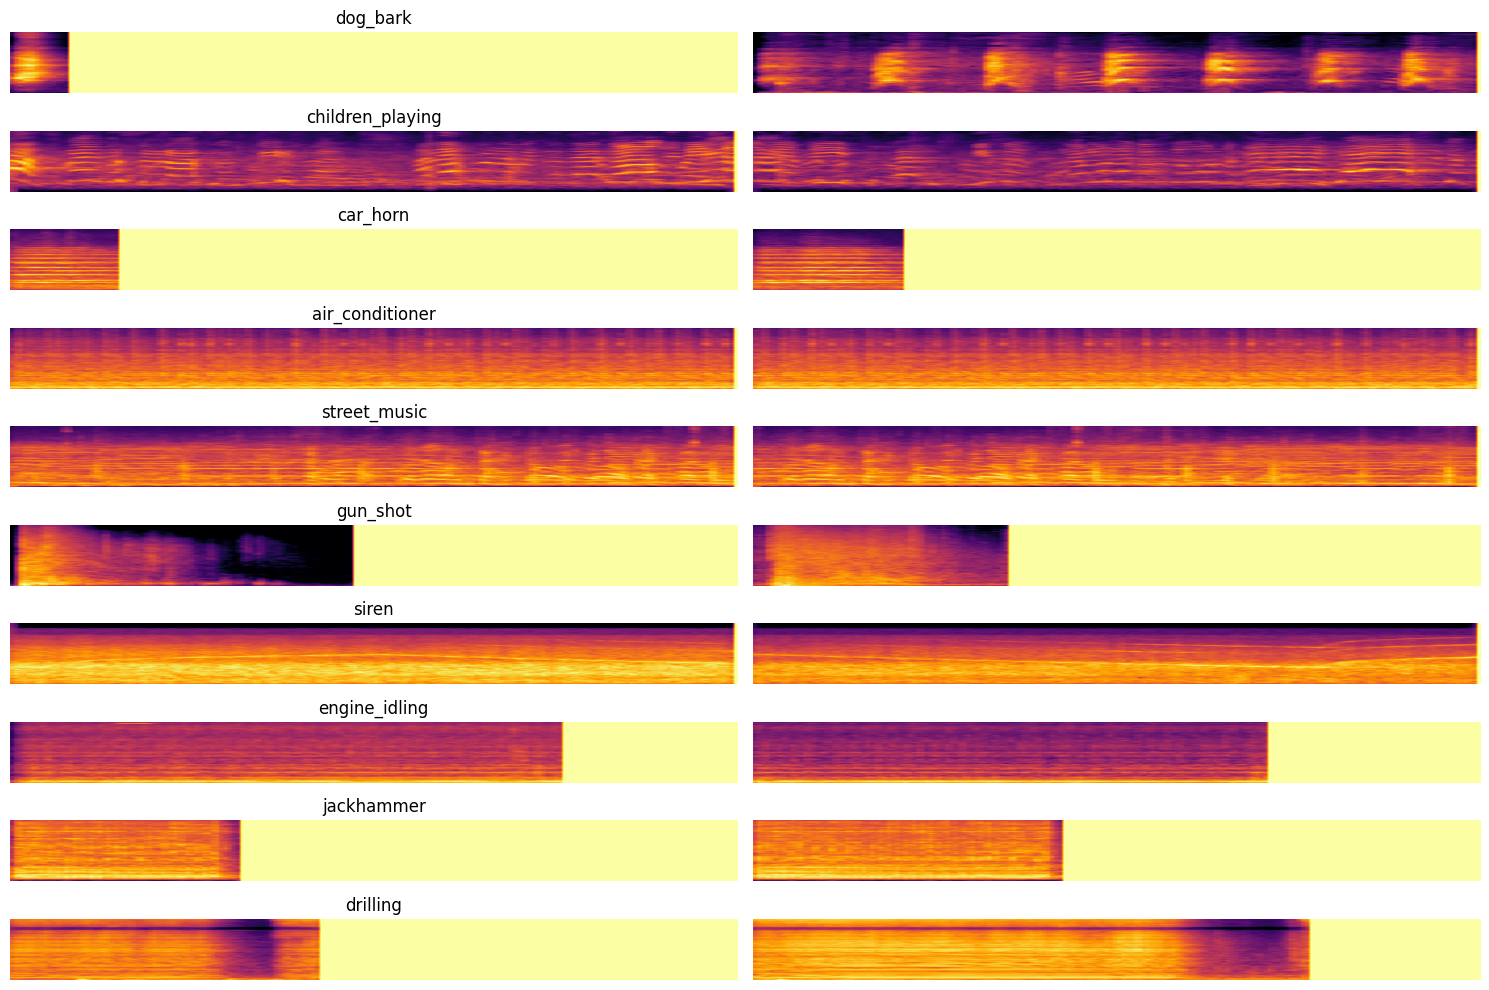

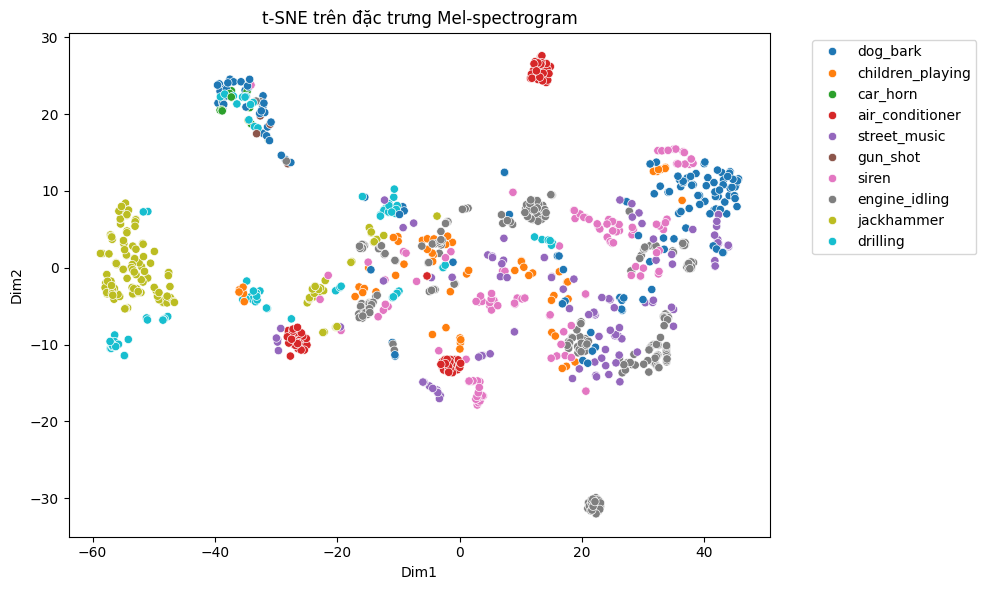

In [5]:
#  TRỰC QUAN HÓA MEL-SPECTROGRAM THEO NHÃN 
def show_spectrograms_per_class(X, y_encoded, label_encoder, samples_per_class=2):
    plt.figure(figsize=(15, 10))
    labels_shown = set()
    i = 0
    for idx, label in enumerate(y_encoded):
        if list(y_encoded).count(label) >= samples_per_class and label not in labels_shown:
            for j in range(samples_per_class):
                try:
                    pos = list(y_encoded).index(label, i)
                    plt.subplot(len(set(y_encoded)), samples_per_class, len(labels_shown)*samples_per_class + j + 1)
                    plt.imshow(X[pos, :, :, 0], origin='lower', aspect='auto', cmap='inferno')
                    plt.axis('off')
                    if j == 0:
                        plt.title(f"{label_encoder.inverse_transform([label])[0]}")
                    i = pos + 1
                except:
                    continue
            labels_shown.add(label)
    plt.tight_layout()
    plt.show()

show_spectrograms_per_class(X, y_encoded, le)

# ======== TRỰC QUAN HÓA T-SNE ========
def visualize_tsne(X, y, label_encoder):
    flat_X = X.reshape((X.shape[0], -1))
    y_labels = np.argmax(y, axis=1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(flat_X[:1000])
    y_tsne = y_labels[:1000]
    df_tsne = pd.DataFrame({'Dim1': X_tsne[:, 0], 'Dim2': X_tsne[:, 1], 'label': label_encoder.inverse_transform(y_tsne)})
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_tsne, x='Dim1', y='Dim2', hue='label', palette='tab10')
    plt.title("t-SNE trên đặc trưng Mel-spectrogram")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualize_tsne(X, y_onehot, le)

In [6]:
# TÁCH TRAIN / TEST 
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, stratify=y_onehot, random_state=42)

# ----------------------------------
# XÂY DỰNG + HUẤN LUYỆN MÔ HÌNH CNNN
# ----------------------------------

In [7]:
# MÔ HÌNH CNN 
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# HUẤN LUYỆN MÔ HÌNH 
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 58s 311ms/step - accuracy: 0.1687 - loss: 3.3682 - val_accuracy: 0.2563 - val_loss: 2.0739
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - accuracy: 0.2782 - loss: 1.8721 - val_accuracy: 0.2534 - val_loss: 1.8257
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 218ms/step - accuracy: 0.3163 - loss: 1.7709 - val_accuracy: 0.4388 - val_loss: 1.6216
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.3356 - loss: 1.6992 - val_accuracy: 0.2334 - val_loss: 1.9537
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 37s 211ms/step - accuracy: 0.3891 - loss: 1.5560 - val_accuracy: 0.5333 - val_loss: 1.3713
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.4315 - loss: 1.4629 - val_accuracy: 0.3930 - val_loss: 1.6303
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 218ms/step - accuracy: 0.4750 - loss: 1.3867 - val_accuracy: 0.6335 - val_loss: 1.1101
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 38s 219ms/step - accuracy: 0.5025 - loss: 1

In [8]:
# Đánh giá mô hình
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(f" Độ chính xác trên tập test: {test_acc:.4f}")
print(" Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
 Độ chính xác trên tập test: 0.6869
 Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.90      0.64      0.74       200
        car_horn       1.00      0.40      0.57        86
children_playing       0.82      0.54      0.65       200
        dog_bark       0.76      0.55      0.64       200
        drilling       0.74      0.60      0.66       200
   engine_idling       0.54      0.91      0.68       200
        gun_shot       0.26      0.93      0.40        75
      jackhammer       0.86      0.72      0.78       200
           siren       0.91      0.82      0.86       186
    street_music       0.81      0.76      0.78       200

        accuracy                           0.69      1747
       macro avg       0.76      0.69      0.68      1747
    weighted avg       0.78      0.69      0.70      1747



# ---------------------------
# Dự đoán 1 file với tên folder + tên file
# ---------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
File: C:\Users\ADMIN\OneDrive\Documents\BTAPKPDL\cuoiki\code\archive\audio\fold1\7061-6-0-0.wav
🔍 Nhãn thật: gun_shot
🔮 Dự đoán: gun_shot


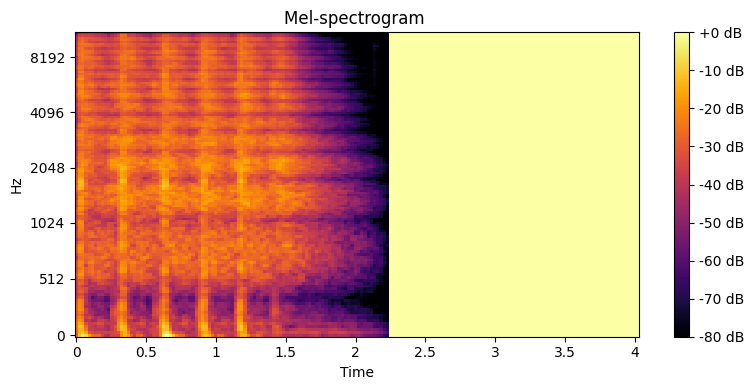

In [9]:
def predict_from_fold_and_file(fold_name, file_name):
    file_path = os.path.join(AUDIO_DIR, fold_name, file_name)
    if not os.path.exists(file_path):
        print("\u274c File không tồn tại.")
        return

    mel = extract_mel_spectrogram(file_path)
    mel_input = mel[np.newaxis, ..., np.newaxis]
    prediction = model.predict(mel_input)
    predicted_label = le.inverse_transform([np.argmax(prediction)])[0]

    # Lấy nhãn thật từ DataFrame
    actual_row = df[(df['fold'] == int(fold_name.replace('fold', ''))) & (df['slice_file_name'] == file_name)]
    actual_label = actual_row['class'].values[0] if not actual_row.empty else "Không rõ"

    print(f"File: {file_path}")
    print(f"🔍 Nhãn thật: {actual_label}")
    print(f"🔮 Dự đoán: {predicted_label}")

    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mel, sr=22050, hop_length=512, x_axis='time', y_axis='mel', cmap='inferno')
    plt.title("Mel-spectrogram ")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

predict_from_fold_and_file("fold1", "7061-6-0-0.wav")

In [10]:
# ======== DỰ ĐOÁN NGẪU NHIÊN MỘT FILE TỪ TẬP TEST ========
# Lấy chỉ số ngẫu nhiên trong tập test
rand_idx = random.randint(0, len(X_test) - 1)

# Dữ liệu và nhãn thật
sample = X_test[rand_idx][np.newaxis, ...]  # thêm batch dimension
true_label = le.inverse_transform([np.argmax(y_test[rand_idx])])[0]

# Dự đoán
pred_probs = model.predict(sample)
pred_label = le.inverse_transform([np.argmax(pred_probs)])[0]

print("\n Dự đoán ngẫu nhiên 1 file từ tập test:")
print(f" Nhãn thật     : {true_label}")
print(f" Nhãn dự đoán : {pred_label}")
print(f" Độ chính xác tổng thể trên tập test: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

 Dự đoán ngẫu nhiên 1 file từ tập test:
 Nhãn thật     : air_conditioner
 Nhãn dự đoán : air_conditioner
 Độ chính xác tổng thể trên tập test: 0.6869


# ---------------------------------------------------
# TRỰC QUAN HÓA KẾT QUẢ DỰ ĐOÁN VÀ ĐÁNH GIÁ MÔ HÌNH
# ---------------------------------------------------

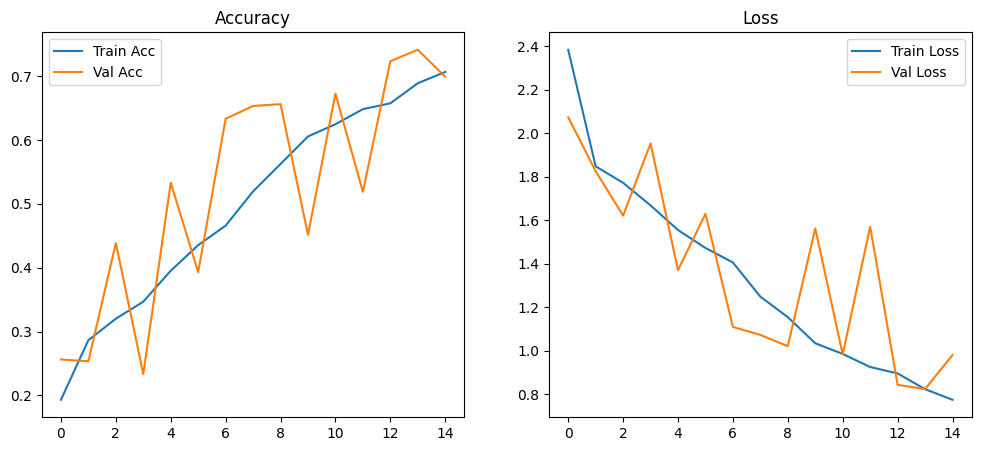

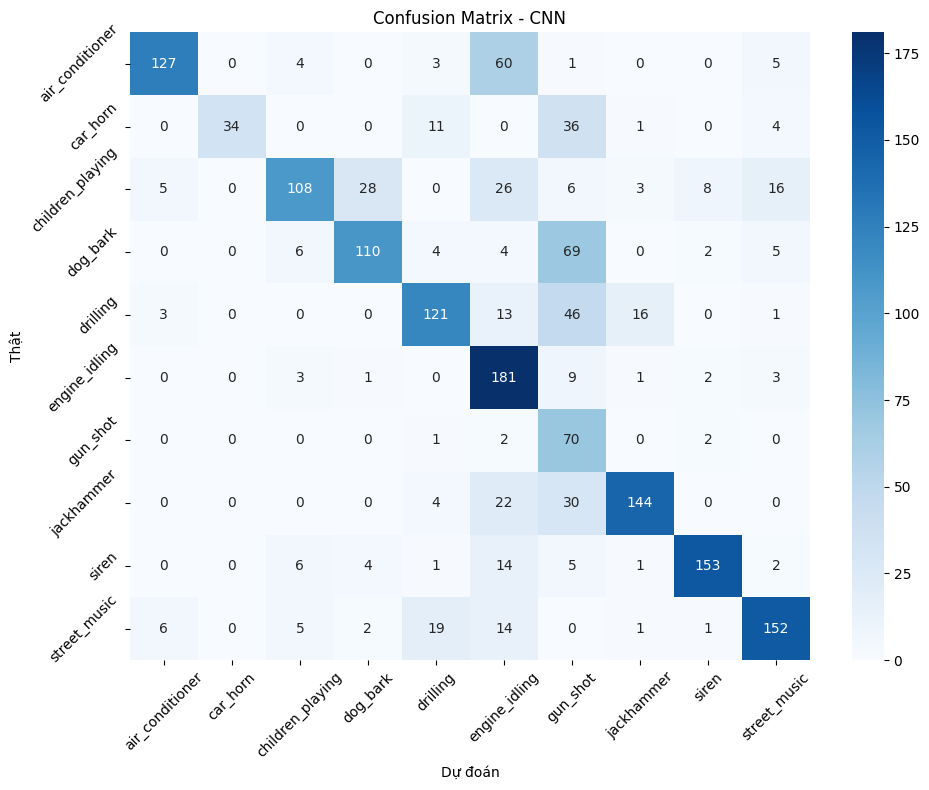

 Bảng đúng/sai theo lớp:
                  precision    recall  f1-score  correct  incorrect
air_conditioner    0.900709  0.635000  0.744868      127         73
car_horn           1.000000  0.395349  0.566667       34         52
children_playing   0.818182  0.540000  0.650602      108         92
dog_bark           0.758621  0.550000  0.637681      110         90
drilling           0.737805  0.605000  0.664835      121         79
engine_idling      0.538690  0.905000  0.675373      181         19
gun_shot           0.257353  0.933333  0.403458       70          5
jackhammer         0.862275  0.720000  0.784741      144         56
siren              0.910714  0.822581  0.864407      153         33
street_music       0.808511  0.760000  0.783505      152         48


<Figure size 1400x600 with 0 Axes>

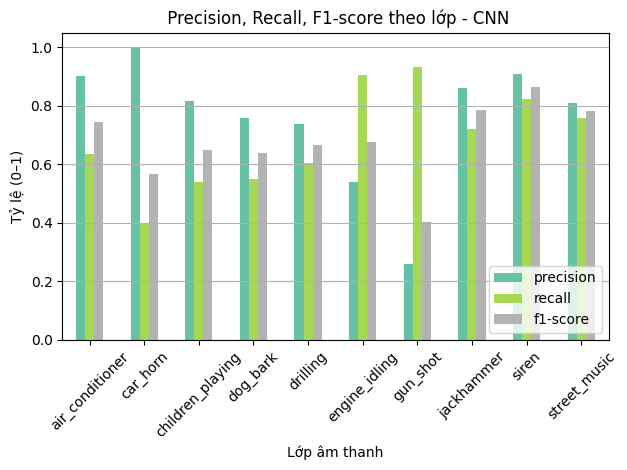

<Figure size 1400x600 with 0 Axes>

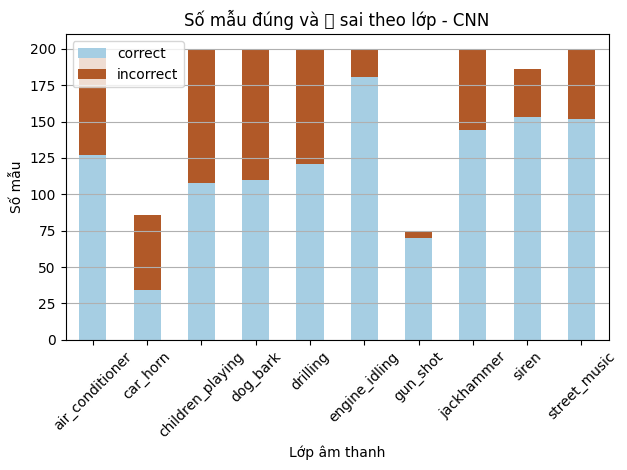

In [11]:
#  BIỂU ĐỒ LOSS & ACCURACY 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# ======== CONFUSION MATRIX & PHÂN TÍCH ========
cm = confusion_matrix(y_true_labels, y_pred_labels)
labels_sorted = le.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='Blues')
plt.title("Confusion Matrix - CNN")
plt.xlabel("Dự đoán")
plt.ylabel("Thật")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

report_dict = classification_report(y_true_labels, y_pred_labels, target_names=labels_sorted, output_dict=True)
report_df = pd.DataFrame(report_dict).T.iloc[:-3]
correct = np.diag(cm)
total = np.sum(cm, axis=1)
incorrect = total - correct
report_df['correct'] = correct
report_df['incorrect'] = incorrect
report_df = report_df[['precision', 'recall', 'f1-score', 'correct', 'incorrect']]
print(" Bảng đúng/sai theo lớp:")
print(report_df)

plt.figure(figsize=(14, 6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', colormap='Set2')
plt.title(" Precision, Recall, F1-score theo lớp - CNN")
plt.xlabel("Lớp âm thanh")
plt.ylabel("Tỷ lệ (0–1)")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
report_df[['correct', 'incorrect']].plot(kind='bar', stacked=True, colormap='Paired')
plt.title("Số mẫu đúng và ❌ sai theo lớp - CNN")
plt.xlabel("Lớp âm thanh")
plt.ylabel("Số mẫu")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()